In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import fasttext
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import torch.nn.functional as F
import torch

import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import norm
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import SGConv

from tqdm import tqdm

import random

import shap

sns.set_theme()

# Set fixed random number seed
#torch.manual_seed(42)

%matplotlib inline

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    return (accuracy_score(true_labels, predicted_labels),
           precision_score(true_labels, predicted_labels),
           recall_score(true_labels, predicted_labels))

def print_evaluation_results(results):
    print('Avg accuracy | Avg precision | Avg recall')
    avg_accuracy, avg_precision, avg_recall = np.mean(results, axis=0)
    std_accuracy, std_precision, std_recall = np.std(results, axis=0)
    print(f'{avg_accuracy:.4f}+-{std_accuracy:.4f}, {avg_precision:.4f}+-{std_precision:.4f}, {avg_recall:.4f}+-{std_recall:.4f}')

def get_random_number():
    return random.randint(0, 10000)

global_random_number = get_random_number()
global_random_numbers = [get_random_number() for _ in range(10)]

## Load dataset

In [3]:
df = pd.read_csv('samples.csv')
# bug == 0 and feature == 1
df = df[(df['label'] == 0) | (df['label'] == 1)]
#df = df[:500]
len(df)

407799

## Preprocess dataset

In [4]:
contractions.add('__label__', 'REMOVED_TOKEN')

In [5]:
# fix contractions
df['title'] = df['title'].apply(contractions.fix)
df['body'] = df['body'].apply(contractions.fix)

In [6]:
# removal of stopwords
df['title'] = df['title'].apply(remove_stopwords)
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [7]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()
df['number_of_words_of_body'] = df['body'].str.split().str.len()

In [8]:
x = df['number_of_words_of_title']

In [9]:
x.describe()

count    407799.000000
mean          4.966165
std           2.007483
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          43.000000
Name: number_of_words_of_title, dtype: float64

Text(0.5, 0, 'Number of words of title')

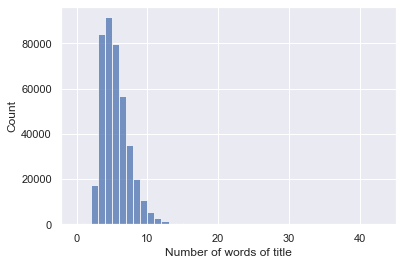

In [10]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('Number of words of title')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

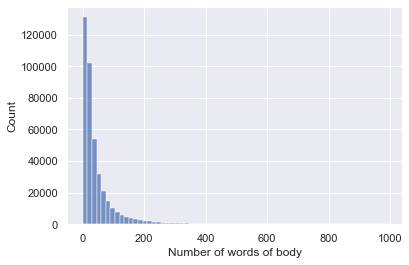

In [11]:
fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=15)
fig.set_xlabel('Number of words of body')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [12]:
df['number_of_words_of_title'].describe()

count    407799.000000
mean          4.966165
std           2.007483
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          43.000000
Name: number_of_words_of_title, dtype: float64

In [13]:
df['number_of_words_of_body'].describe()

count    407799.000000
mean         45.938685
std          63.545595
min           0.000000
25%          12.000000
50%          24.000000
75%          52.000000
max         977.000000
Name: number_of_words_of_body, dtype: float64

In [14]:
# bugs == 0
# feature == 1
df['label'].value_counts()

1    207318
0    200481
Name: label, dtype: int64

In [15]:
x_train, x_test = train_test_split(df.body, test_size=0.33, random_state=42)
print('Train size', len(x_train))
print('Test size', len(x_test))

Train size 273225
Test size 134574


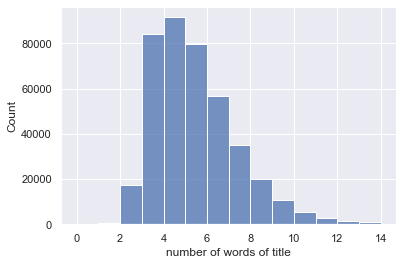

In [16]:
fig = sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('number of words of title')
fig.get_figure().savefig('figures/number_of_words_of_title_less_than_15.pdf', dpi=500)

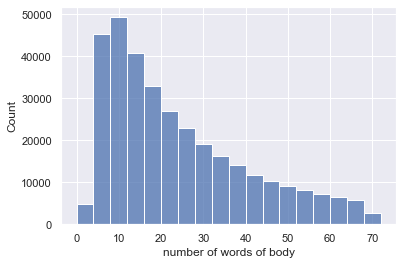

In [17]:
fig = sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4)
fig.set_xlabel('number of words of body')
fig.get_figure().savefig('figures/number_of_words_of_body_less_than_70.pdf', dpi=500)

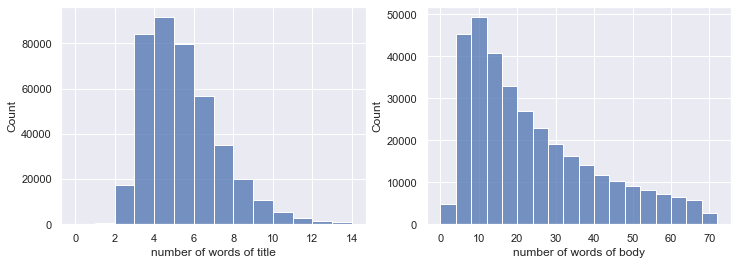

In [18]:
# print altogether
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)
ax[0].set_xlabel('number of words of title')
ax[1].set_xlabel('number of words of body')
sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1, ax=ax[0])
sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4, ax=ax[1])
fig.savefig('figures/title_words_less_than_15_body_words_less_than_70.pdf', dpi=500)

## Load glove embeddings 100

In [19]:
glove2word2vec('glove.6B/glove.6B.100d.txt', 'tmpfile_glove')
glove_embeddings_model = KeyedVectors.load_word2vec_format('tmpfile_glove')

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).


In [20]:
def get_word_glove_embedding(word):
    if word not in glove_embeddings_model:
        return np.zeros(100, dtype='float32')
    return glove_embeddings_model.get_vector(word)

In [21]:
def get_sentence_glove_embedding(sentence):
    word_embeddings = [glove_embeddings_model.get_vector(word) if word in glove_embeddings_model else np.zeros(100, dtype='float32') for word in sentence.split()]
    if len(word_embeddings) == 0:
        return np.zeros(100, dtype='float32')
    return np.mean(word_embeddings, axis=0)

## Train fasttext embeddings

In [22]:
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
np.savetxt('train.txt', train_input, fmt='%s')
np.savetxt('test.txt', test_input, fmt='%s')
fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
fasttext_model.test('test.txt')
df.drop('fasttext_input', axis=1, inplace=True)
embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

## Train baseline models

## GloVe + logistic regression classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
X_train = [get_sentence_glove_embedding(s) for s in X_train.values]
X_test = [get_sentence_glove_embedding(s) for s in X_test.values]

In [ ]:
def run_logistic_regression_classifier(use_global_random_number=True):
    if use_global_random_number:
        random_state = global_random_number
    else:
        random_state = get_random_number()
    logit_clf = LogisticRegression(random_state=random_state, solver='liblinear').fit(X_train, y_train)
    predicted_labels = logit_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [ ]:
logit_evaluation_results = [run_logistic_regression_classifier()]

## <font color='red'>GloVe + logistic regression results</font>

In [ ]:
print_evaluation_results(logit_evaluation_results)

## GloVe + knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def run_knn_regression_classifier():
    knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    predicted_labels = knn_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [ ]:
knn_evaluation_results = [run_knn_regression_classifier()]

## <font color='red'>GloVe + knn results</font>

In [ ]:
print_evaluation_results(knn_evaluation_results)

## Fasttext classification

In [ ]:
def run_fasttext_classifier():
    df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
    train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
    np.savetxt('train.txt', train_input, fmt='%s')
    np.savetxt('test.txt', test_input, fmt='%s')
    fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
    fasttext_model.test('test.txt')
    df.drop('fasttext_input', axis=1, inplace=True)
    embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

    _, test_df = train_test_split(df, test_size=0.33, random_state=42)
    predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]
    true_labels = test_df['label'].values
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [ ]:
fasttext_evaluation_results = []
for num in global_random_numbers:
    fasttext_evaluation_results.append(run_fasttext_classifier())

## <font color='red'>Fasttext results</font>

In [ ]:
print_evaluation_results(fasttext_evaluation_results)

## MLP

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x_train, x_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
x_train = [get_sentence_glove_embedding(s) for s in x_train.values]
x_test = [get_sentence_glove_embedding(s) for s in x_test.values]

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.values).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.values).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

BATCH_SIZE = 255

# generate train dataset and train dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# generate test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self) : 
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(100 , 250)
        self.linear2 = torch.nn.Linear(250, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
def run_mlp_classifier():
    # Initialize the MLP
    mlp = MLP().to(device)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    mlp.train()
    # Run the training loop
    for epoch in range(0, 50):
        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dataloader):
            # Get inputs
            targets = targets.squeeze()

            # Perform forward pass
            outputs = mlp(inputs)
            outputs = outputs.squeeze()

            # Compute loss
            loss = loss_function(outputs, targets)


            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Zero the gradients
            optimizer.zero_grad()

        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')
    # Process is complete.
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    with torch.no_grad():
        mlp.eval()
        pred = mlp(test_dataset.tensors[0].to(device))
        y_true = test_dataset.tensors[1].tolist()
        y_pred = torch.round(torch.tensor(pred.tolist()).squeeze())
        results = calculate_accuracy_precision_recall(y_true, y_pred)

    print(results)
    return results

In [ ]:
mlp_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    mlp_evaluation_results.append(run_mlp_classifier())

## <font color='red'>GloVe + MLP results</font>

In [ ]:
print_evaluation_results(mlp_evaluation_results)

## Train our model

In [36]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def create_graph_of_words(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = embeddings_lookup.get(word, np.zeros(100, dtype='float32'))
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch(text, window_size):
    return from_networkx(create_graph_of_words(text, window_size))

def generate_pytorch_geometric_graphs(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        #self.conv1 = GATConv(100, 10, heads=3)
        self.conv1 = SGConv(100, 50, K=1)
        self.linear1 = torch.nn.Linear(10*5, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        h = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(h)
        x = self.sigmoid(x)
        
        return h, x

In [30]:
pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=7)

100%|█████████████████████████████████████████████████| 407799/407799 [20:21<00:00, 333.71it/s]


finished...


In [31]:
train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

In [37]:
def run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs, batch_size=200, shuffle=False)
    
    gat_model = GATClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                _, out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            _, out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
            
    #print('true labels ----')
    #print(true_labels)
    #print('pred labels ----')
    #print(pred_labels)
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return {
        'model': gat_model,
        'results': results
    }

In [38]:
gat_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_evaluation_results.append(run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results'])

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.3446064889431
Epoch: 1, Epoch loss 0.3434496819972992
Epoch: 2, Epoch loss 0.34211021661758423
Epoch: 3, Epoch loss 0.35209256410598755
Epoch: 4, Epoch loss 0.353280246257782
Epoch: 5, Epoch loss 0.34084728360176086
Epoch: 6, Epoch loss 0.35327771306037903
Epoch: 7, Epoch loss 0.3437592685222626
Epoch: 8, Epoch loss 0.34147462248802185
Epoch: 9, Epoch loss 0.357673317193985
Training process has finished.
Final loss 0.357673317193985
(0.8027776539301796, 0.8166833015757796, 0.7892667670227848)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.34338057041168213
Epoch: 1, Epoch loss 0.35319092869758606
Epoch: 2, Epoch loss 0.34215882420539856
Epoch: 3, Epoch loss 0.34182316064834595
Epoch: 4, Epoch loss 0.3524443209171295
Epoch: 5, Epoch loss 0.35293805599212646
Epoch: 6, Epoch loss 0.3540140390396118
Epoch: 7, Epoch loss 0.353135883808136
Epoch: 8, Epoch loss 0.34889352321624756
Epoch: 9, Epoch loss 0.34355491399765015
Training process has finished.
Final loss 0.34355491399765015
(0.802681052803662, 0.8155209573618292, 0.7908013387311285)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.3479885458946228
Epoch: 1, Epoch loss 0.3509548008441925
Epoch: 2, Epoch loss 0.3532697558403015
Epoch: 3, Epoch loss 0.33759957551956177
Epoch: 4, Epoch loss 0.35386544466018677
Epoch: 5, Epoch loss 0.35054337978363037
Epoch: 6, Epoch loss 0.3459223508834839
Epoch: 7, Epoch loss 0.34807589650154114
Epoch: 8, Epoch loss 0.3553924858570099
Epoch: 9, Epoch loss 0.34869226813316345
Training process has finished.
Final loss 0.34869226813316345
(0.8028593933449255, 0.8167137910700516, 0.7894275316779445)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.3446800112724304
Epoch: 1, Epoch loss 0.35039666295051575
Epoch: 2, Epoch loss 0.3528206944465637
Epoch: 3, Epoch loss 0.3417188227176666
Epoch: 4, Epoch loss 0.3507686257362366
Epoch: 5, Epoch loss 0.34774115681648254
Epoch: 6, Epoch loss 0.343904048204422
Epoch: 7, Epoch loss 0.3552398979663849
Epoch: 8, Epoch loss 0.36225634813308716
Epoch: 9, Epoch loss 0.3561335504055023
Training process has finished.
Final loss 0.3561335504055023
(0.8027553613625217, 0.8168091383614494, 0.7890183125557195)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.34802567958831787
Epoch: 1, Epoch loss 0.3522244393825531
Epoch: 2, Epoch loss 0.3576834797859192
Epoch: 3, Epoch loss 0.3490036725997925
Epoch: 4, Epoch loss 0.34919270873069763
Epoch: 5, Epoch loss 0.34760960936546326
Epoch: 6, Epoch loss 0.3494594693183899
Epoch: 7, Epoch loss 0.3423284590244293
Epoch: 8, Epoch loss 0.34679076075553894
Epoch: 9, Epoch loss 0.34588634967803955
Training process has finished.
Final loss 0.34588634967803955
(0.8027850847860657, 0.8163894302678693, 0.7897344460196133)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.3525170683860779
Epoch: 1, Epoch loss 0.352100670337677
Epoch: 2, Epoch loss 0.3556331992149353
Epoch: 3, Epoch loss 0.351597398519516
Epoch: 4, Epoch loss 0.3465810716152191
Epoch: 5, Epoch loss 0.34838107228279114
Epoch: 6, Epoch loss 0.3489486873149872
Epoch: 7, Epoch loss 0.35474520921707153
Epoch: 8, Epoch loss 0.3499526381492615
Epoch: 9, Epoch loss 0.337254136800766
Training process has finished.
Final loss 0.337254136800766
(0.8027404996507498, 0.8170050415587955, 0.7886821682767491)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.3440572917461395
Epoch: 1, Epoch loss 0.3449517786502838
Epoch: 2, Epoch loss 0.3518224358558655
Epoch: 3, Epoch loss 0.3567434251308441
Epoch: 4, Epoch loss 0.3499496579170227
Epoch: 5, Epoch loss 0.35461464524269104
Epoch: 6, Epoch loss 0.34980958700180054
Epoch: 7, Epoch loss 0.3534184396266937
Epoch: 8, Epoch loss 0.3512839078903198
Epoch: 9, Epoch loss 0.34532132744789124
Training process has finished.
Final loss 0.34532132744789124
(0.8028296699213815, 0.8162245406368427, 0.7900998202358855)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.35184386372566223
Epoch: 1, Epoch loss 0.34090501070022583
Epoch: 2, Epoch loss 0.34919074177742004
Epoch: 3, Epoch loss 0.34839195013046265
Epoch: 4, Epoch loss 0.35706403851509094
Epoch: 5, Epoch loss 0.34120485186576843
Epoch: 6, Epoch loss 0.34864678978919983
Epoch: 7, Epoch loss 0.35276496410369873
Epoch: 8, Epoch loss 0.3608187437057495
Epoch: 9, Epoch loss 0.3539724051952362
Training process has finished.
Final loss 0.3539724051952362
(0.8026959145154339, 0.8171036488390058, 0.788419098841033)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.34718793630599976
Epoch: 1, Epoch loss 0.36111199855804443
Epoch: 2, Epoch loss 0.34730273485183716
Epoch: 3, Epoch loss 0.3537960648536682
Epoch: 4, Epoch loss 0.3469322919845581
Epoch: 5, Epoch loss 0.35828620195388794
Epoch: 6, Epoch loss 0.3523618280887604
Epoch: 7, Epoch loss 0.35021016001701355
Epoch: 8, Epoch loss 0.3460008502006531
Epoch: 9, Epoch loss 0.3540070354938507
Training process has finished.
Final loss 0.3540070354938507
(0.8028073773537237, 0.81627352079495, 0.7899682855180276)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch: 0, Epoch loss 0.34989869594573975
Epoch: 1, Epoch loss 0.3558759391307831
Epoch: 2, Epoch loss 0.3498704731464386
Epoch: 3, Epoch loss 0.3509600758552551
Epoch: 4, Epoch loss 0.34485843777656555
Epoch: 5, Epoch loss 0.34759750962257385
Epoch: 6, Epoch loss 0.3573731482028961
Epoch: 7, Epoch loss 0.34890836477279663
Epoch: 8, Epoch loss 0.3452059328556061
Epoch: 9, Epoch loss 0.34611186385154724
Training process has finished.
Final loss 0.34611186385154724
(0.8027776539301796, 0.8162910826486225, 0.7898659807374713)


## <font color='red'>Our approach results</font>

In [39]:
print_evaluation_results(gat_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8028+-0.0001, 0.8165+-0.0004, 0.7895+-0.0007


## Glove + GATConv

In [ ]:
def create_graph_of_words_glove(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = get_word_glove_embedding(word)
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [ ]:
pytorch_geometric_graphs_glove = generate_pytorch_geometric_graphs_glove(window_size=7)

In [ ]:
train_pyg_graphs_glove, test_pyg_graphs_glove = train_test_split(pytorch_geometric_graphs_glove, test_size=0.33, random_state=42)

In [ ]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [ ]:
gat_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_glove_evaluation_results.append(run_gat_glove_classifier())

## <font color='red'>GloVe + GATConv results</font>

In [ ]:
print_evaluation_results(gat_glove_evaluation_results)

## Glove + GCNonv

In [ ]:
class GCNGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GCNConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [ ]:
def run_gcn_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GCNGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [ ]:
gcn_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gcn_glove_evaluation_results.append(run_gcn_glove_classifier())

## <font color='red'>GloVe + GCNConv results</font>

In [ ]:
print_evaluation_results(gcn_glove_evaluation_results)

## Glove + GraphConv

In [ ]:
class GraphConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GraphConv(100, 10, aggr='mean')
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [ ]:
def run_graphconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GraphConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [ ]:
graphconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    graphconv_glove_evaluation_results.append(run_graphconv_glove_classifier())

## <font color='red'>GloVe + GraphConv results</font>

In [ ]:
print_evaluation_results(graphconv_glove_evaluation_results)

## Glove + SAGEConv

In [ ]:
class SAGEConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = SAGEConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [ ]:
def run_sageconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = SAGEConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [ ]:
sageconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    sageconv_glove_evaluation_results.append(run_sageconv_glove_classifier())

## <font color='red'>GloVe + SAGEConv results</font>

In [ ]:
print_evaluation_results(sageconv_glove_evaluation_results)

In [ ]:
del pytorch_geometric_graphs_glove
del train_pyg_graphs_glove
del test_pyg_graphs_glove

# Parameter Sensitivity

In [ ]:
torch.manual_seed(12345)

## Sliding window

In [ ]:
def run_sliding_window_experiments():
    sliding_windows = [2, 3, 4, 6, 7, 10]
    
    sliding_window_results = []
    for sw in sliding_windows:
        print('Window size:', sw)
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        sliding_window_results.append((sw, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results']))
    return sliding_window_results

In [ ]:
sliding_window_results = run_sliding_window_experiments()
sliding_window_results = [[sw, results[0]] for sw, results in sliding_window_results]

## <font color='red'>Sliding window results</font>

In [ ]:
plot_x = [res[0] for res in sliding_window_results]
plot_y = [res[1] for res in sliding_window_results]
sliding_window_results

In [ ]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('window size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_window_size.pdf', dpi=500)

## Learning rate

In [ ]:
def run_learning_rate_experiments():
    learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    
    learning_rate_results = []
    for lr in learning_rates:
        print('Learning rate:', lr)
        #pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=2)
        #train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        learning_rate_results.append((lr, run_gat_classifier(train_pyg_graphs, test_pyg_graphs, learning_rate=lr)['results']))
    return learning_rate_results

In [ ]:
learning_rate_results = run_learning_rate_experiments()
learning_rate_results = [[lr, results[0]] for lr, results in learning_rate_results]

## <font color='red'>Learning rate results</font>

In [ ]:
plot_x = [res[0] for res in learning_rate_results]
plot_y = [res[1] for res in learning_rate_results]
learning_rate_results

In [ ]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('learning rate')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_learning_rate.pdf', dpi=500)

## Dataset size

In [ ]:
len(pytorch_geometric_graphs)

In [ ]:
def run_training_size_experiments():
    training_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    training_size_results = []
    for ts in training_sizes:
        print('Training size:', ts)
        if ts == 1:
            print('All samples')
            tmp_graphs = pytorch_geometric_graphs
        else:
            tmp_graphs, _ = train_test_split(pytorch_geometric_graphs, train_size=ts, random_state=42)
        
        print('Number of samples:', len(tmp_graphs))
        train_pyg_graphs, test_pyg_graphs = train_test_split(tmp_graphs, test_size=0.33, random_state=42)
        training_size_results.append((ts, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results']))
    return training_size_results

In [ ]:
training_size_results = run_training_size_experiments()
training_size_results = [[ts, results[0]] for ts, results in training_size_results]

## <font color='red'>Dataset size results</font>

In [ ]:
plot_x = [res[0] for res in training_size_results]
plot_y = [res[1] for res in training_size_results]
training_size_results

In [ ]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('dataset size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/training_size_rate.pdf', dpi=500)

## Draw an exemplar graph-of-words graph with 15 nodes and 3 window size

In [ ]:
text = df['body'][df['number_of_words_of_body'] == 15].values[6]
text = text.replace(',', '')
text = text.replace('.', '')
g = create_graph_of_words(text, 3)
nx.draw_kamada_kawai(g, with_labels=True, node_color='white', node_size=1300)
plt.savefig("Graph1.pdf")
plt.show()

## Documents visualization

In [ ]:
from sklearn.manifold import TSNE
def run_document_visualization_experiment():
    sw = 7
    print('Window size:', sw)
    pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)
    train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
    model = run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['model']
    
    loader = DataLoader(pytorch_geometric_graphs, batch_size=100, shuffle=False)
    documents_embeddings = []
    
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(loader):
            data = data.to(device)
            embeddings, out = model(data, data.batch)
            documents_embeddings.extend(embeddings.tolist())
            pred_labels.extend(torch.round(out.squeeze()).tolist())
    
    print('Number of documents:', len(documents_embeddings))
    print('Number of dimensions per document:', len(documents_embeddings[0]))
    return documents_embeddings, pred_labels

In [ ]:
documents_embeddings, pred_labels = run_document_visualization_experiment()
documents_embeddings = np.array(documents_embeddings)
visualization_x_y = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42).fit_transform(np.array(documents_embeddings))

In [ ]:
fig = sns.scatterplot(x=visualization_x_y[:, 0], y=visualization_x_y[:, 1], hue=pred_labels)
fig.set_xlabel('')
fig.set_ylabel('')
fig.get_figure().savefig('figures/documents_visualization.jpg', dpi=500)

## Documents visualization fastText

In [ ]:
predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(df['body'].values.tolist())[0]]
fasttext_document_embeddings = [fasttext_model.get_sentence_vector(doc) for doc in df['body'].values.tolist()]
visualization_x_y_fasttext = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42).fit_transform(np.array(fasttext_document_embeddings))

In [ ]:
fig = sns.scatterplot(x=visualization_x_y_fasttext[:, 0], y=visualization_x_y_fasttext[:, 1], hue=df['label'])
fig.set_xlabel('')
fig.set_ylabel('')
fig.get_figure().savefig('figures/fasttext_real_labels_documents_visualization.jpg', dpi=500)

## Explainability

In [ ]:
num = global_random_numbers[0]
torch.manual_seed(num)
result = run_gat_classifier(train_pyg_graphs, test_pyg_graphs)

In [ ]:
fast_gat_conv_model = result['model']

In [ ]:
type(fast_gat_conv_model)

In [ ]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [ ]:
fast_gat_conv_model('jfdkslj ')

In [ ]:
# explain th model on two sample inputs
explainer = shap.Explainer(fasttext_model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

In [ ]:
# ...include code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])